# 3.6 Predicting house prices: a regression example

Another common type of machine-learning problem is **regression**, which consists of 
**predicting a continuous value** instead of a discrete label: for instance, predicting 
the temperature tomorrow, given meteorological data; or predicting the time that a 
software project will take to complete, given its specifications.

You’ll attempt to predict the median price of homes in a given Boston suburb in the
mid-1970s, given data points about the suburb at the time, such as the crime rate, the
local property tax rate, and so on. The dataset you’ll use has an interesting difference
from the two previous examples. It has relatively few data points: only 506, split
between 404 training samples and 102 test samples. And each feature in the input data
(for example, the crime rate) has a different scale. For instance, some values are 
proportions, which take values between 0 and 1; others take values between 1 and 12, 
others between 0 and 100, and so on.

In [1]:
# Loading the Boston housing dataset

from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [2]:
type(train_data)

numpy.ndarray

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets[:20]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5])

In [6]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [8]:
# Model definition

from keras import models
from keras import layers

def build_model():
    
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
    
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

  return model

In [10]:
# K-fold validation

import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
num_val_samples

101

In [11]:
%%time

# Validating your approach using K-fold validation

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], 
      axis=0)
  
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
      axis=0)
  
  model = build_model()
  model.fit(partial_train_data, 
            partial_train_targets, 
            epochs=num_epochs, 
            batch_size=1, 
            verbose=0)
  
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
CPU times: user 1min 10s, sys: 4.11 s, total: 1min 14s
Wall time: 47.8 s


In [12]:
all_scores

[2.2494328022003174, 2.308941125869751, 2.8028666973114014, 2.607492685317993]

In [13]:
np.mean(all_scores)

2.4921833276748657

In [14]:
%%time

# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
      axis=0)
  
  partial_train_targets = np.concatenate(
      [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
      axis=0)

  model = build_model()
  history = model.fit(
      partial_train_data, 
      partial_train_targets,
      validation_data=(val_data, val_targets),
      epochs=num_epochs, 
      batch_size=1, 
      verbose=0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
CPU times: user 6min 28s, sys: 23.4 s, total: 6min 52s
Wall time: 4min 9s


In [15]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [16]:
mae_history = history.history['val_mae']
all_mae_histories.append(mae_history)

In [17]:
# Building the history of successive mean K-fold validation scores

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

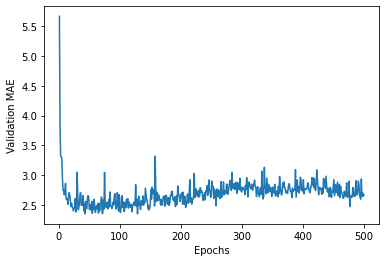

In [18]:
# Plotting validation scores

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

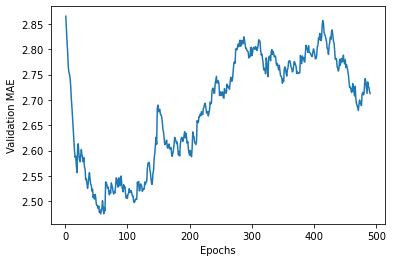

In [19]:
# Plotting validation scores, excluding the first 10 data points

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [23]:
%%time

# Training the final model

model = build_model()

model.fit(
    train_data, 
    train_targets,
    epochs=70, 
    batch_size=16, 
    verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mae_score

4/4 [==============================] - 0s 687us/step - loss: 17.3882 - mae: 2.5152
CPU times: user 1.75 s, sys: 64 ms, total: 1.82 s
Wall time: 1.24 s


2.5152103900909424

## Wrapping up

Here’s what you should take away from this example:

- Regression is done using **different loss functions** than what we used for classification. **Mean squared error (MSE)** is a loss function **commonly used for regression**.

- Similarly, **evaluation metrics** to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A **common regression metric** is **mean absolute error (MAE)**.

- When features in the input data have values in different ranges, **each feature should be scaled independently** as a preprocessing step.

- When there is **little data available**, using **K-fold validation** is a great way to reliably evaluate a model.

- When **little training data** is available, it’s preferable to **use a small network with few hidden layers** (typically only one or two), in order to avoid severe overfitting. 